# End to End Walkthrough

> Model training, evaluation and selection for multiple time series

:::{.callout-warning collapse="true"}
## Prerequesites
This Guide assumes basic familiarity with NeuralForecast. For a minimal example visit the [Quick Start](../getting-started/02_quickstart.ipynb)
:::

Follow this article for a step to step guide on building a production-ready forecasting pipeline for multiple time series. 

During this guide you will gain familiarity with the core `NeuralForecast`class and some relevant methods like `NeuralForecast.fit`, `NeuralForecast.predict`, and `StatsForecast.cross_validation.`

We will use a classical benchmarking dataset from the M4 competition. The dataset includes time series from different domains like finance, economy and sales. In this example, we will use a subset of the Hourly dataset. 

We will model each time series globally Therefore, you will train a set of models for the whole dataset, and then select the best model for each individual time series. NeuralForecast focuses on speed, simplicity, and scalability, which makes it ideal for this task.


**Outline:**

1. Install packages.
1. Read the data.
2. Explore the data.
3. Train many models globally for the entire dataset. 
4. Evaluate the model's performance using cross-validation. 
5. Select the best model for every unique time series.

:::{.callout-tip collapse=true}
## Not Covered in this guide

* Using external regressors or exogenous variables
    * Follow this tutorial to [include exogenous variables](../capabilities/03_exogenous_variables.ipynb) like weather or holidays or static variables like category or family. 

* Probabilistic forecasting
    * Follow this tutorial to [generate probabilistic forecasts](../tutorials/03_uncertainty_quantification.ipynb)

* Transfer Learning
    * Train a model and use it to forecast on different data using [this tutorial](../tutorials/17_transfer_learning.ipynb)
:::

::: {.callout-tip}
You can use Colab to run this Notebook interactively <a href="https://colab.research.google.com/github/Nixtla/neuralforecast/blob/main/nbs/examples/Getting_Started_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
::: 

::: {.callout-warning}
To reduce the computation time, it is recommended to use GPU. Using Colab, do not forget to activate it. Just go to `Runtime>Change runtime type` and select GPU as hardware accelerator.
::: 

## 1. Install libraries

We assume you have `NeuralForecast` already installed. Check this guide for instructions on [how to install NeuralForecast](../getting-started/04_installation.ipynb).

In [ ]:
%%capture
! pip install neuralforecast

## 2. Read the data

We will use pandas to read the M4 Hourly data set stored in a parquet file for efficiency. You can use ordinary pandas operations to read your data in other formats likes `.csv`. 

The input to `NeuralForecast` is always a data frame in [long format](https://www.theanalysisfactor.com/wide-and-long-data/) with three columns: `unique_id`, `ds` and `y`:

* The `unique_id` (string, int or category) represents an identifier for the series. 

* The `ds` (datestamp or int) column should be either an integer indexing time or a datestampe ideally like YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.

* The `y` (numeric) represents the measurement we wish to forecast. 
We will rename the 

This data set already satisfies the requirement.  

Depending on your internet connection, this step should take around 10 seconds. 

In [ ]:
import pandas as pd

In [ ]:
Y_df = pd.read_parquet('https://datasets-nixtla.s3.amazonaws.com/m4-hourly.parquet')
Y_df.head()

,unique_id,ds,y
0,H1,1,605.0
1,H1,2,586.0
2,H1,3,586.0
3,H1,4,559.0
4,H1,5,511.0


This dataset contains 414 unique series with 900 observations on average. For this example and reproducibility's sake, we will select only 10 unique IDs. Depending on your processing infrastructure feel free to select more or less series. 

:::{.callout-note}
Processing time is dependent on the available computing resources. Running this example with the complete dataset takes around 10 minutes in a c5d.24xlarge (96 cores) instance from AWS.
:::

In [ ]:
uids = Y_df['unique_id'].unique()[:10] # Select 10 ids to make the example faster
Y_df = Y_df.query('unique_id in @uids').reset_index(drop=True)

## 3. Explore Data with the plot_series function

Plot some series using the `plot_series` function from the `utilsforecast` library. This method prints 8 random series from the dataset and is useful for basic EDA.

:::{.callout-note}
The `plot_series` function uses matplotlib as a default engine. You can change to plotly by setting `engine="plotly"`. 
:::

In [ ]:
from utilsforecast.plotting import plot_series

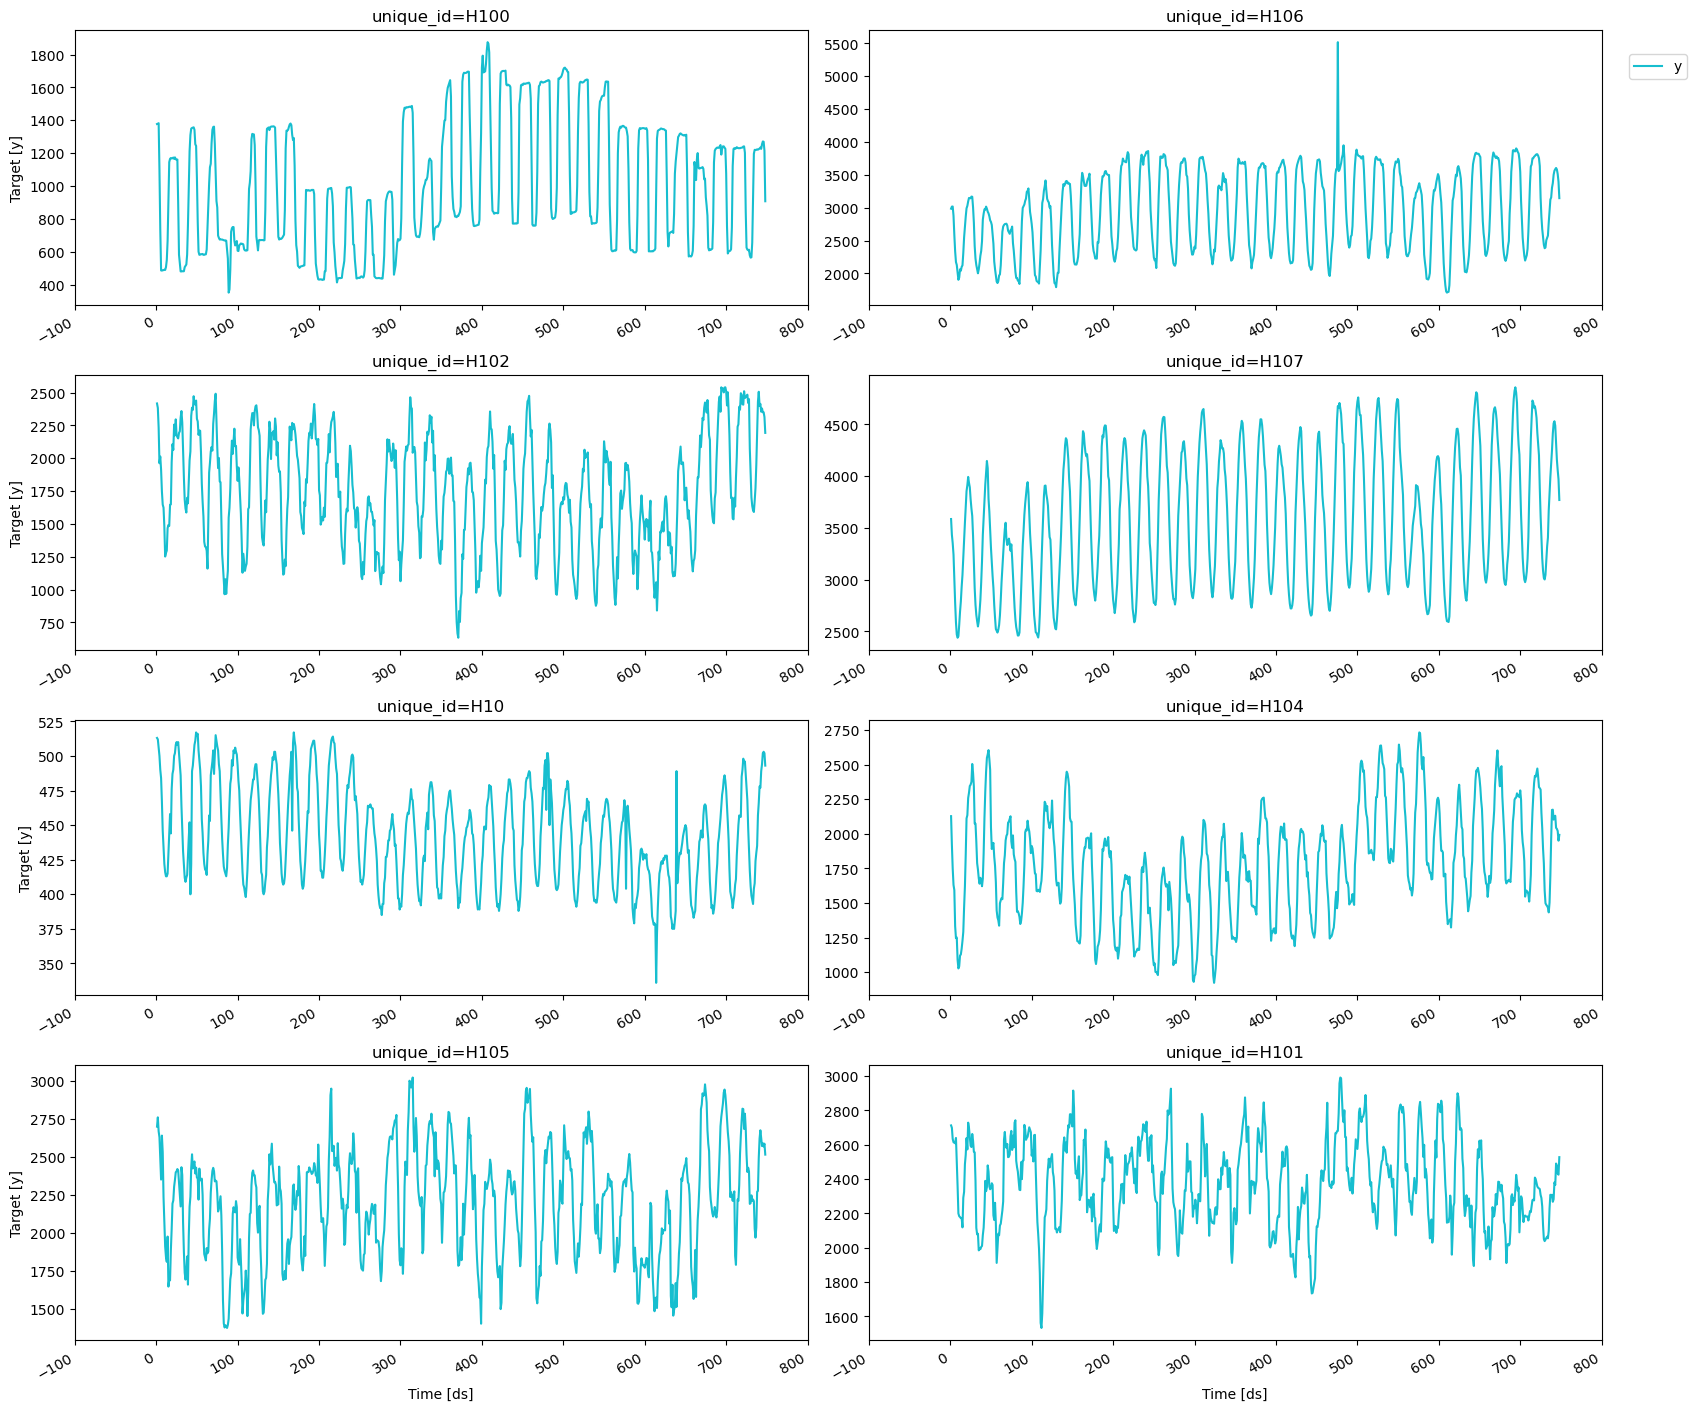

In [ ]:
plot_series(Y_df)

## 4. Train multiple models for many series

`NeuralForecast` can train many models on many time series globally and efficiently. 

In [ ]:
import logging

import optuna
import ray.tune as tune
import torch

from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoNHITS, AutoLSTM
from neuralforecast.losses.pytorch import MQLoss

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
logging.getLogger('pytorch_lightning').setLevel(logging.ERROR)
torch.set_float32_matmul_precision('high')

Each `Auto` model contains a default search space that was extensively tested on multiple large-scale datasets. Additionally, users can define specific search spaces tailored for particular datasets and tasks.

First, we create a custom search space for the `AutoNHITS` and `AutoLSTM` models. Search spaces are specified with dictionaries, where keys corresponds to the model's hyperparameter and the value is a `Tune` function to specify how the hyperparameter will be sampled. For example, use `randint` to sample integers uniformly, and `choice` to sample values of a list.


In [ ]:
def config_nhits(trial):
    return {
        "input_size": trial.suggest_categorical(          # Length of input window
            "input_size", (48, 48*2, 48*3)                
        ),                                                
        "start_padding_enabled": True,                                          
        "n_blocks": 5 * [1],                              # Length of input window
        "mlp_units": 5 * [[64, 64]],                      # Length of input window
        "n_pool_kernel_size": trial.suggest_categorical(  # MaxPooling Kernel size
            "n_pool_kernel_size",
            (5*[1], 5*[2], 5*[4], [8, 4, 2, 1, 1])
        ),     
        "n_freq_downsample": trial.suggest_categorical(   # Interpolation expressivity ratios
            "n_freq_downsample",
            ([8, 4, 2, 1, 1],  [1, 1, 1, 1, 1])
        ),     
        "learning_rate": trial.suggest_float(             # Initial Learning rate
            "learning_rate",
            low=1e-4,
            high=1e-2,
            log=True,
        ),            
        "scaler_type": None,                              # Scaler type
        "max_steps": 1000,                                # Max number of training iterations
        "batch_size": trial.suggest_categorical(          # Number of series in batch
            "batch_size",
            (1, 4, 10),
        ),                   
        "windows_batch_size": trial.suggest_categorical(  # Number of windows in batch
            "windows_batch_size",
            (128, 256, 512),
        ),      
        "random_seed": trial.suggest_int(                 # Random seed   
            "random_seed",
            low=1,
            high=20,
        ),                      
    }

def config_lstm(trial):
    return {
        "input_size": trial.suggest_categorical(           # Length of input window
            "input_size",
            (48, 48*2, 48*3)
        ),   
        "encoder_hidden_size": trial.suggest_categorical(  # Hidden size of LSTM cells
            "encoder_hidden_size",
            (64, 128),
        ),  
        "encoder_n_layers": trial.suggest_categorical(     # Number of layers in LSTM
            "encoder_n_layers",
            (2,4),
        ),        
        "learning_rate": trial.suggest_float(              # Initial Learning rate
            "learning_rate",
            low=1e-4,
            high=1e-2,
            log=True,
        ),   
        "scaler_type": 'robust',                           # Scaler type
        "max_steps": trial.suggest_categorical(           # Max number of training iterations
            "max_steps",
            (500, 1000)
        ),          
        "batch_size": trial.suggest_categorical(           # Number of series in batch
            "batch_size",
            (1, 4)
        ),              
        "random_seed": trial.suggest_int(                  # Random seed
            "random_seed",
            low=1,
            high=20
        ),             
    }

To instantiate an `Auto` model you need to define:

* `h`: forecasting horizon.
* `loss`: training and validation loss from `neuralforecast.losses.pytorch`.
* `config`: hyperparameter search space. If `None`, the `Auto` class will use a pre-defined suggested hyperparameter space.
* `search_alg`: search algorithm
* `num_samples`: number of configurations explored.

In this example we set horizon `h` as 48, use the `MQLoss` distribution loss for training and validation, and use the default search algorithm. 

In [ ]:
nf = NeuralForecast(
    models=[
        AutoNHITS(h=48, config=config_nhits, loss=MQLoss(), backend='optuna', num_samples=5),
        AutoLSTM(h=48, config=config_lstm, loss=MQLoss(), backend='optuna', num_samples=2),
    ],
    freq=1,
)

:::{.callout-tip}
The number of samples, `num_samples`, is a crucial parameter! Larger values will usually produce better results as we explore more configurations in the search space, but it will increase training times. Larger search spaces will usually require more samples. As a general rule, we recommend setting `num_samples` higher than 20.
:::

Next, we use the `Neuralforecast` class to train the `Auto` model. In this step, `Auto` models will automatically perform hyperparameter tuning training multiple models with different hyperparameters, producing the forecasts on the validation set, and evaluating them. The best configuration is selected based on the error on a validation set. Only the best model is stored and used during inference.

In [ ]:
%%capture
nf.fit(df=Y_df)

Next, we use the `predict` method to forecast the next 48 days using the optimal hyperparameters.

In [ ]:
fcst_df = nf.predict()
fcst_df.columns = fcst_df.columns.str.replace('-median', '')
fcst_df.head()

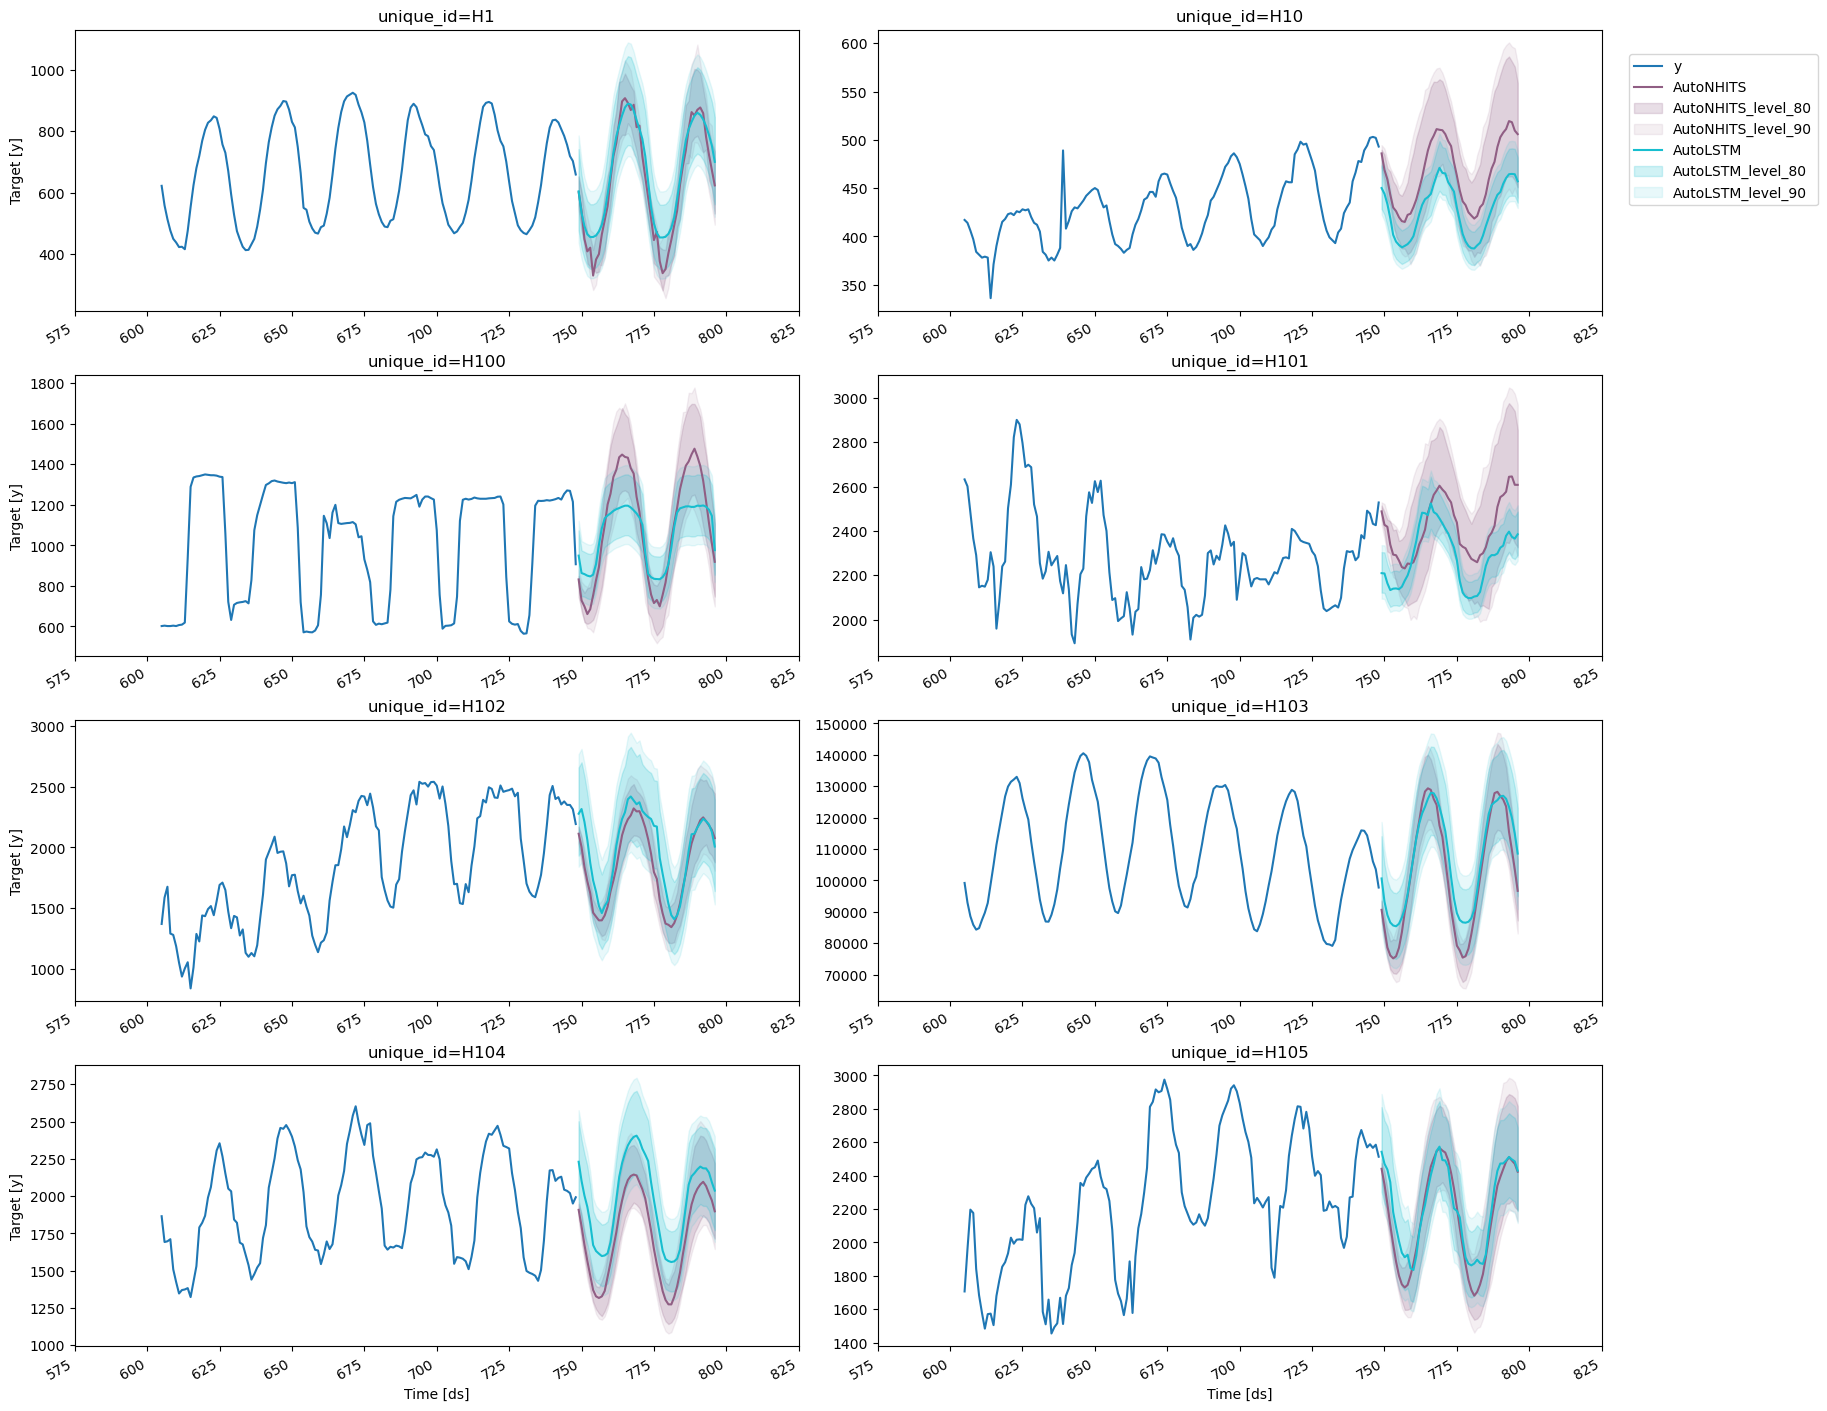

In [ ]:
plot_series(Y_df, fcst_df, plot_random=False, max_insample_length=48 * 3, level=[80, 90])

The `plot_series` function allows for further customization. For example, plot the results of the different models and unique ids. 

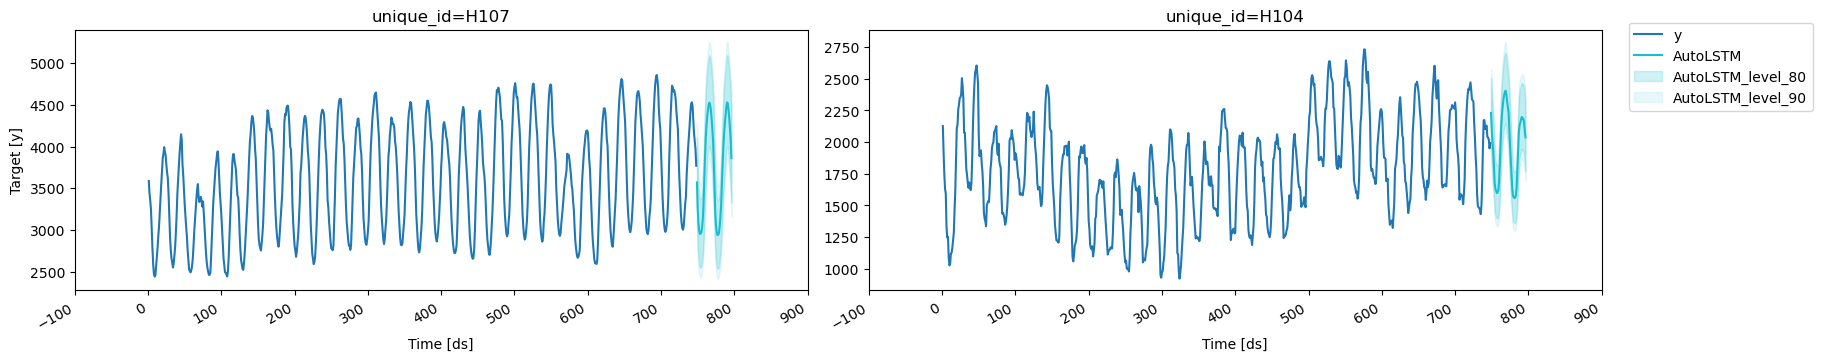

In [ ]:
# Plot to unique_ids and some selected models
plot_series(Y_df, fcst_df, models=["AutoLSTM"], ids=["H107", "H104"], level=[80, 90])

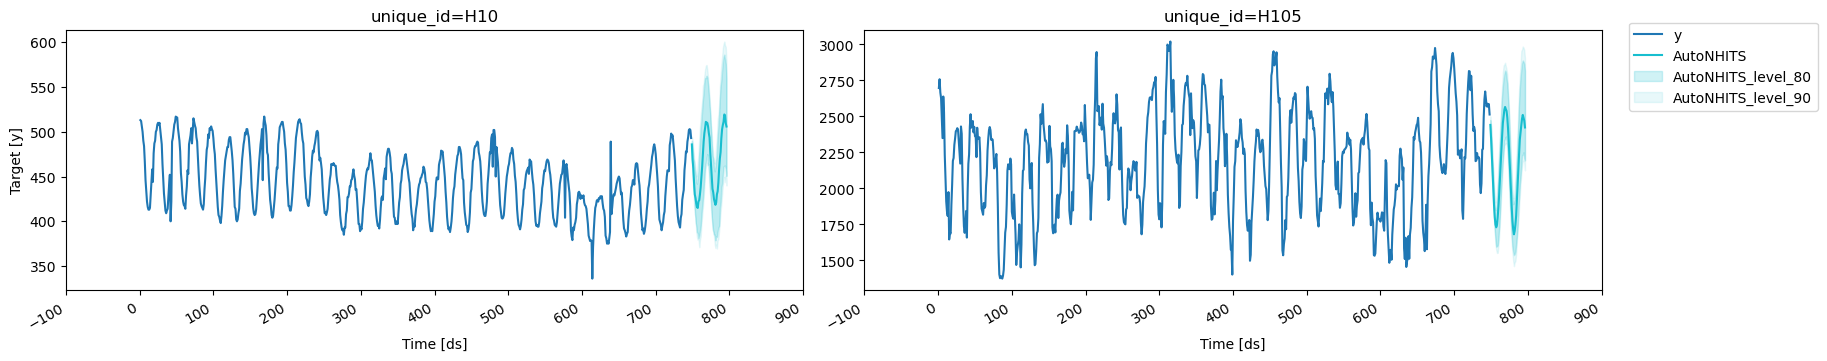

In [ ]:
# Explore other models 
plot_series(Y_df, fcst_df, models=["AutoNHITS"], ids=["H10", "H105"], level=[80, 90])

## 5. Evaluate the model's performance


In previous steps, we've taken our historical data to predict the future. However, to asses its accuracy we would also like to know how the model would have performed in the past. To assess the accuracy and robustness of your models on your data perform Cross-Validation.

With time series data, **Cross Validation** is done by defining a sliding window across the historical data and predicting the period following it. This form of cross-validation allows us to arrive at a better estimation of our model's predictive abilities across a wider range of temporal instances while also keeping the data in the training set contiguous as is required by our models.

The following graph depicts such a Cross Validation Strategy:

![](https://raw.githubusercontent.com/Nixtla/statsforecast/main/nbs/imgs/ChainedWindows.gif)

:::{.callout-tip}
Setting `n_windows=1` mirrors a traditional train-test split with our historical data serving as the training set and the last 48 hours serving as the testing set. 
:::


The `cross_validation` method from the `NeuralForecast` class takes the following arguments.

- `df`: training data frame

- `step_size` (int): step size between each window. In other words: how often do you want to run the forecasting processes.
- `n_windows` (int): number of windows used for cross validation. In other words: what number of forecasting processes in the past do you want to evaluate.


In [ ]:
from neuralforecast.auto import AutoNHITS, AutoLSTM

In [ ]:
nf = NeuralForecast(
    models=[
        AutoNHITS(h=48, config=config_nhits, loss=MQLoss(), num_samples=5, backend="optuna"),
        AutoLSTM(h=48, config=config_lstm, loss=MQLoss(), num_samples=2, backend="optuna"), 
    ],
    freq=1,
)

In [ ]:
%%capture
cv_df = nf.cross_validation(Y_df, n_windows=2)

The `cv_df` object is a new data frame that includes the following columns:

- `unique_id`: identifies each time series
- `ds`: datestamp or temporal index
- `cutoff`: the last datestamp or temporal index for the n_windows. If n_windows=1, then one unique cuttoff value, if n_windows=2 then two unique cutoff values.
- `y`: true value
- `"model"`: columns with the model’s name and fitted value.

In [ ]:
cv_df.columns = cv_df.columns.str.replace('-median', '')

In [ ]:
cv_df.head()

,unique_id,ds,cutoff,AutoNHITS,AutoNHITS-lo-90,AutoNHITS-lo-80,AutoNHITS-hi-80,AutoNHITS-hi-90,AutoLSTM,AutoLSTM-lo-90,AutoLSTM-lo-80,AutoLSTM-hi-80,AutoLSTM-hi-90,y
0,H1,700,699,654.506348,615.993774,616.021851,693.879272,712.376587,777.396362,511.052124,585.006470,992.880249,1084.980957,684.0
1,H1,701,699,619.320068,573.836060,577.762695,663.133301,683.214478,691.002991,417.614349,488.192810,905.101135,1002.091919,619.0
2,H1,702,699,546.807922,486.383362,498.541748,599.284302,623.889038,569.914795,314.173462,389.398865,763.250244,852.974121,565.0
3,H1,703,699,483.149811,420.416351,435.613708,536.380005,561.349487,548.401917,305.305054,379.597839,732.263123,817.543152,532.0
4,H1,704,699,434.347931,381.605713,394.665619,481.329041,501.715546,511.798950,269.810272,346.146484,692.443542,776.531921,495.0


In [ ]:
from IPython.display import display

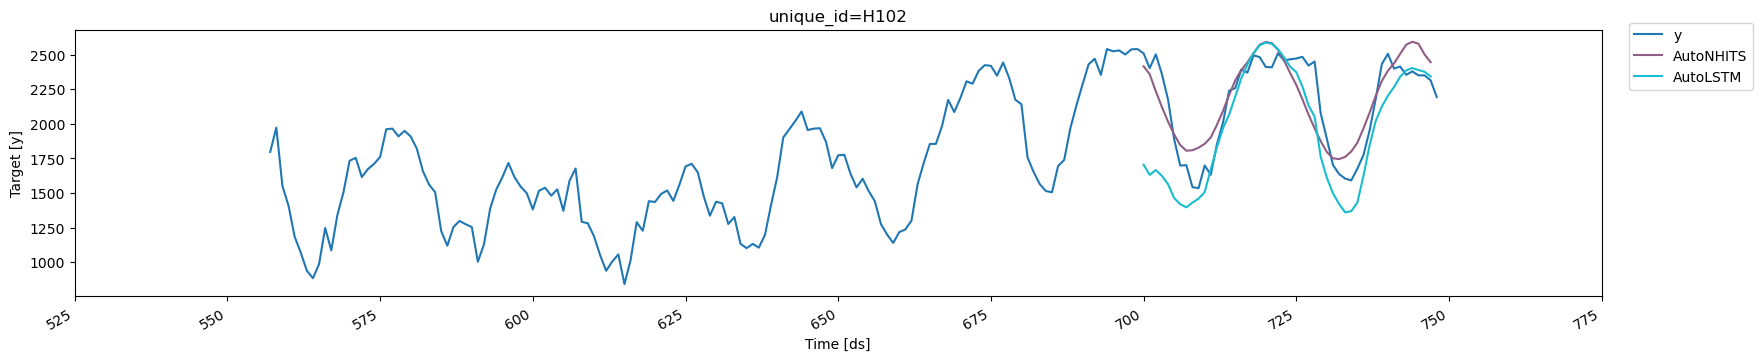

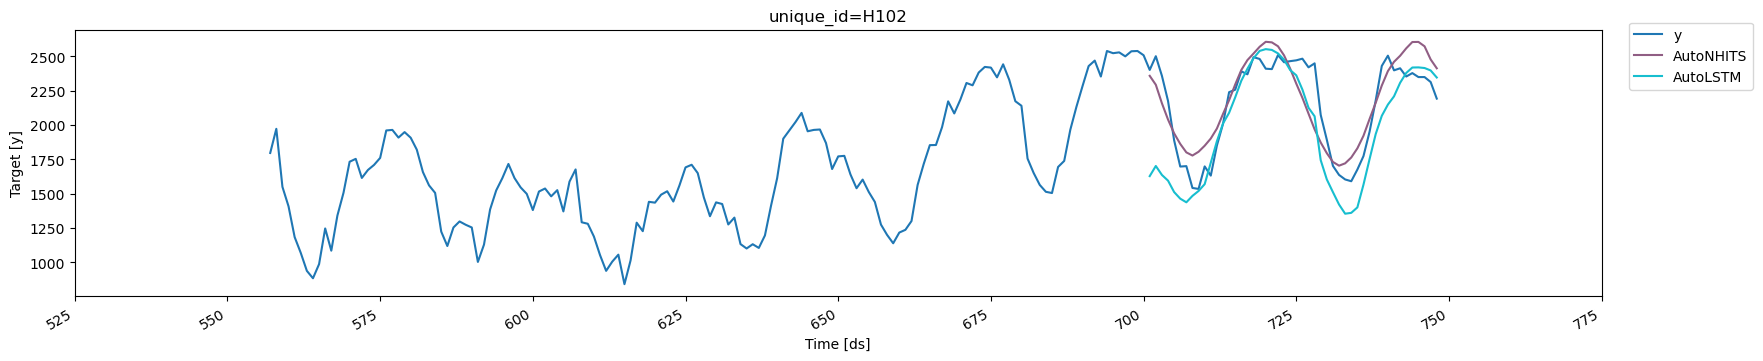

In [ ]:
for cutoff in cv_df['cutoff'].unique():
    display(
        plot_series(
            Y_df,
            cv_df.query('cutoff == @cutoff').drop(columns=['y', 'cutoff']),
            max_insample_length=48 * 4, 
            ids=['H102'],
        )
    )

Now, let's evaluate the models' performance.

In [ ]:
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mse, mae, rmse

:::{.callout-warning}
You can also use Mean Average Percentage Error (MAPE), however for granular forecasts, MAPE values are extremely [hard to judge]("https://blog.blueyonder.com/mean-absolute-percentage-error-mape-has-served-its-duty-and-should-now-retire/") and not useful to assess forecasting quality.
:::

Create the data frame with the results of the evaluation of your cross-validation data frame using a Mean Squared Error metric. 

In [ ]:
evaluation_df = evaluate(cv_df.drop(columns='cutoff'), metrics=[mse, mae, rmse])
evaluation_df['best_model'] = evaluation_df.drop(columns=['metric', 'unique_id']).idxmin(axis=1)
evaluation_df.head()

,unique_id,metric,AutoNHITS,AutoLSTM,best_model
0,H1,mse,2295.630068,1889.340182,AutoLSTM
1,H10,mse,724.468906,362.463659,AutoLSTM
2,H100,mse,62943.031250,17063.347107,AutoLSTM
3,H101,mse,48771.973540,12213.554997,AutoLSTM
4,H102,mse,30671.342050,84569.434859,AutoNHITS


Create a summary table with a model column and the number of series where that model performs best. 

In [ ]:
summary_df = evaluation_df.groupby(['metric', 'best_model']).size().sort_values().to_frame()
summary_df = summary_df.reset_index()
summary_df.columns = ['metric', 'model', 'nr. of unique_ids']
summary_df

,metric,model,nr. of unique_ids
0,mae,AutoNHITS,3
1,mse,AutoNHITS,4
2,rmse,AutoNHITS,4
3,mse,AutoLSTM,6
4,rmse,AutoLSTM,6
5,mae,AutoLSTM,7


In [ ]:
summary_df.query('metric == "mse"')

,metric,model,nr. of unique_ids
1,mse,AutoNHITS,4
3,mse,AutoLSTM,6


You can further explore your results by plotting the unique_ids where a specific model wins.

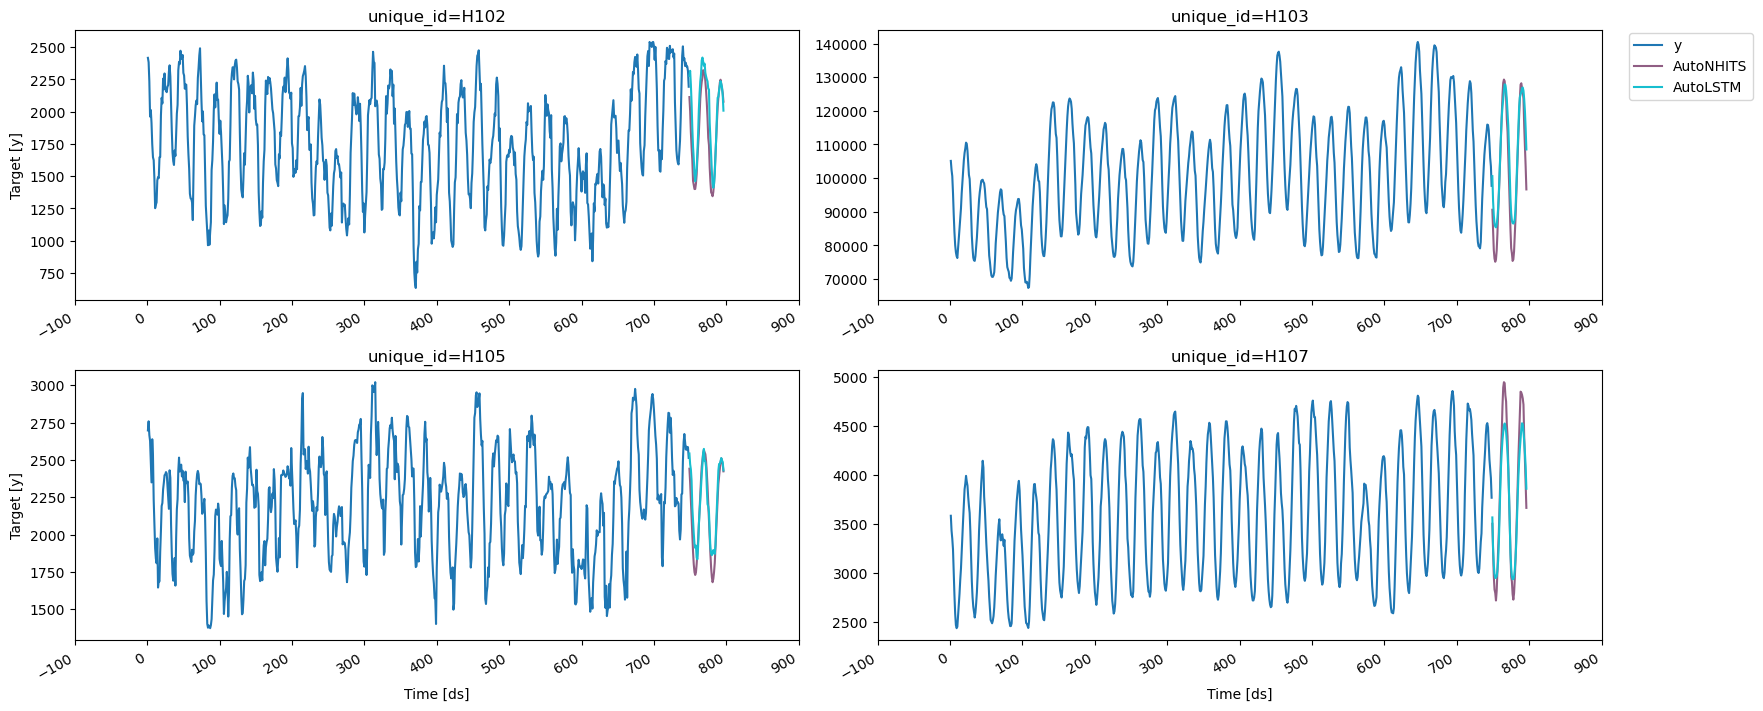

In [ ]:
nhits_ids = evaluation_df.query('best_model == "AutoNHITS" and metric == "mse"')['unique_id'].unique()

plot_series(Y_df, fcst_df, ids=nhits_ids)

## 6. Select the best model for every unique series

Define a utility function that takes your forecast's data frame with the predictions and the evaluation data frame and returns a data frame with the best possible forecast for every unique_id.

In [ ]:
def get_best_model_forecast(forecasts_df, evaluation_df, metric):
    metric_eval = evaluation_df.loc[evaluation_df['metric'] == metric, ['unique_id', 'best_model']]
    with_best = forecasts_df.merge(metric_eval)
    res = with_best[['unique_id', 'ds']].copy()
    for suffix in ('', '-lo-90', '-hi-90'):
        res[f'best_model{suffix}'] = with_best.apply(lambda row: row[row['best_model'] + suffix], axis=1)
    return res

Create your production-ready data frame with the best forecast for every unique_id.

In [ ]:
prod_forecasts_df = get_best_model_forecast(fcst_df, evaluation_df, metric='mse')
prod_forecasts_df

,unique_id,ds,best_model,best_model-lo-90,best_model-hi-90
0,H1,749,603.923767,437.270447,786.502686
1,H1,750,533.691284,383.289154,702.944397
2,H1,751,490.400085,349.417816,648.831299
3,H1,752,463.768066,327.452026,616.572144
4,H1,753,454.710266,320.023468,605.468018
...,...,...,...,...,...
475,H107,792,4720.256348,4142.459961,5235.727051
476,H107,793,4394.605469,3952.059082,4992.124023
477,H107,794,4161.221191,3664.091553,4632.160645
478,H107,795,3945.432617,3453.011963,4437.968750


Plot the results. 

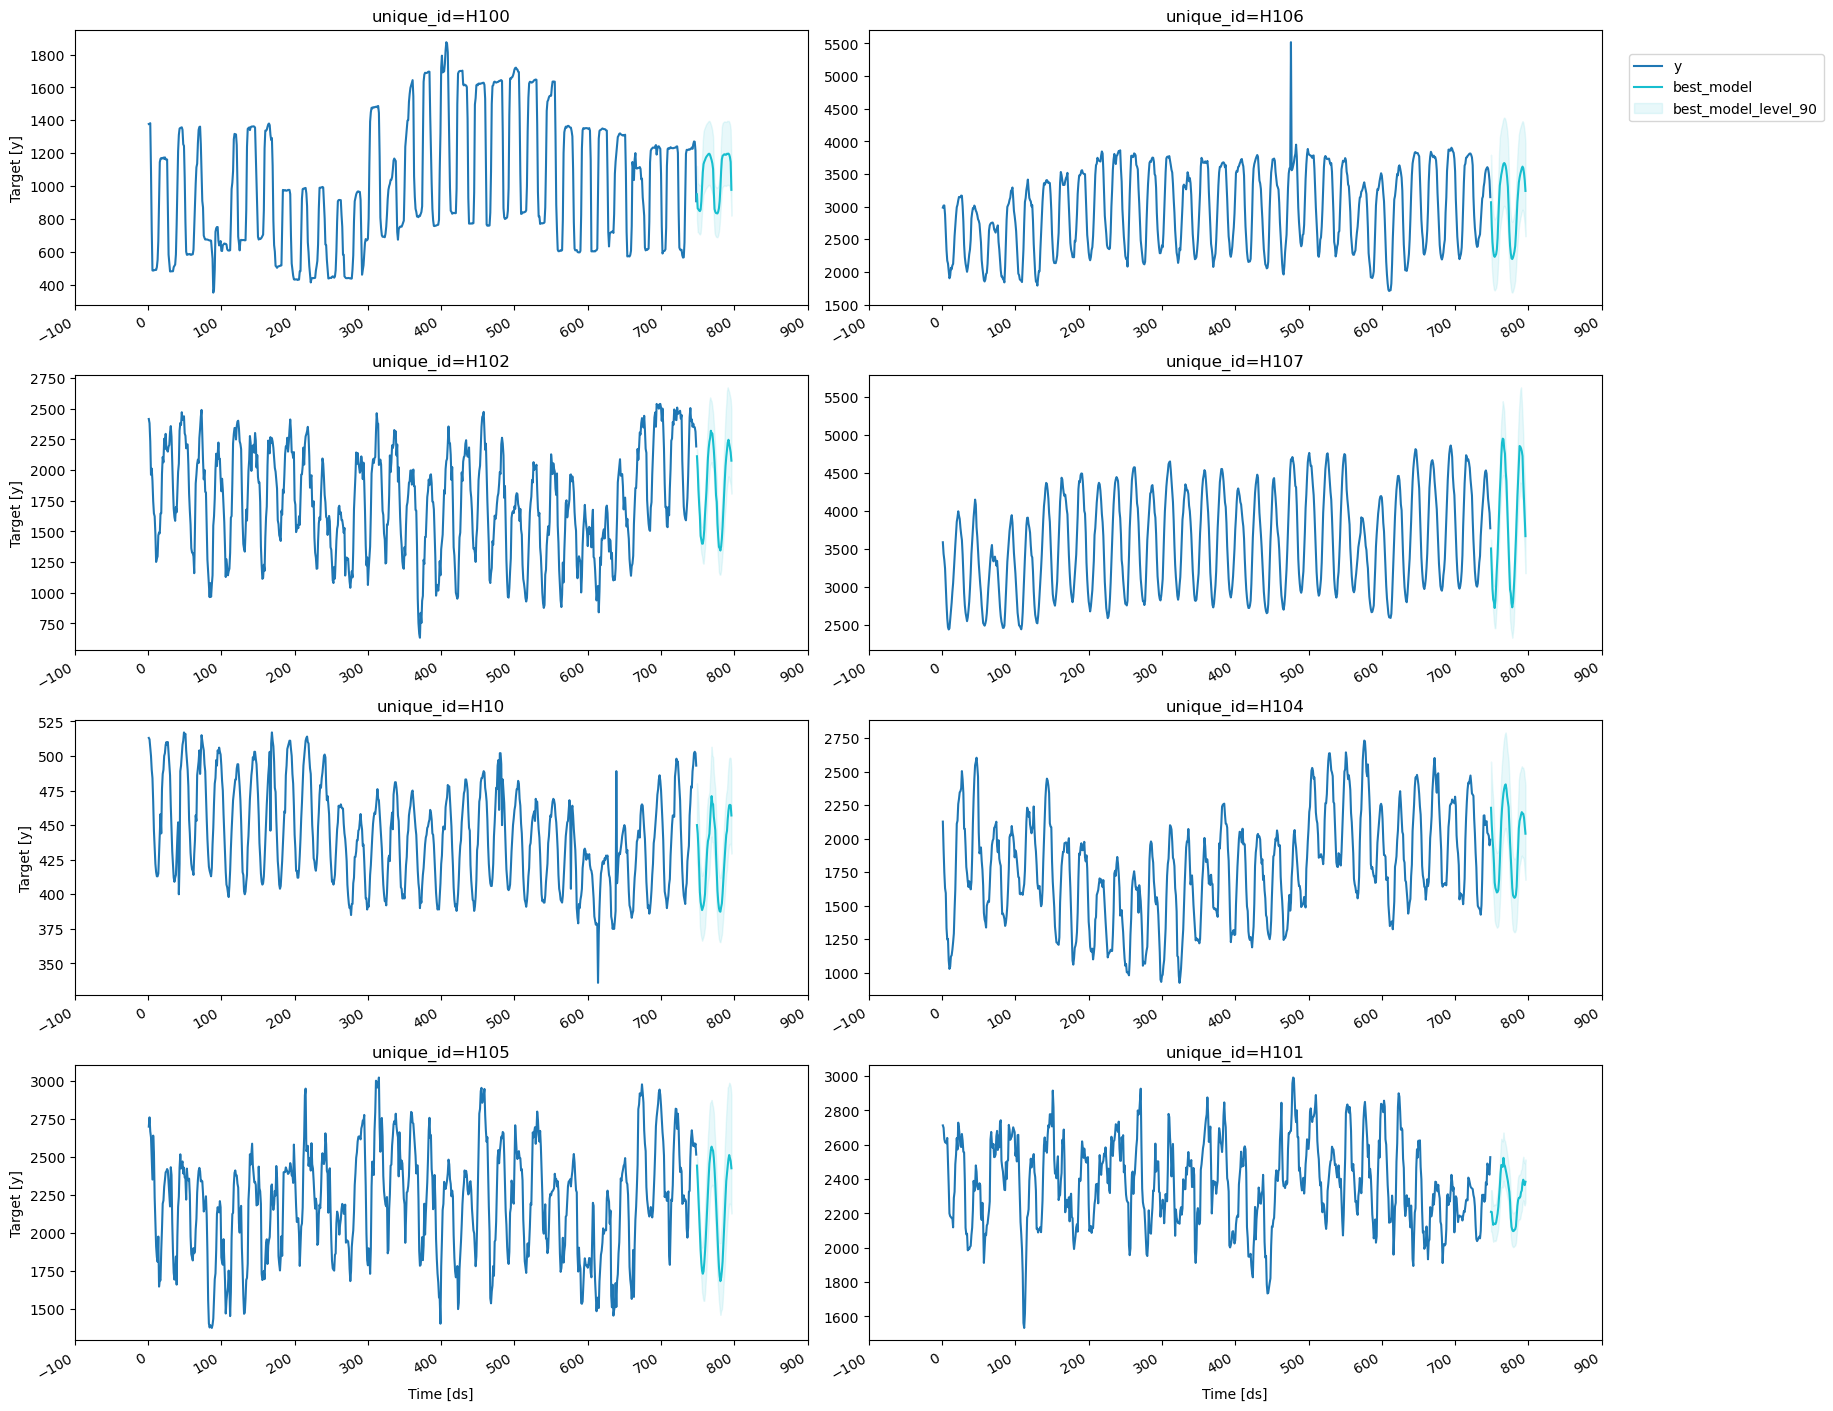

In [ ]:
plot_series(Y_df, prod_forecasts_df, level=[90])